<a href="https://colab.research.google.com/github/Avichay3/final_project_eyal/blob/main/final_project_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:

!pip install transformers datasets evaluate -q
!pip install torch torchvision torchaudio -q
!pip install scikit-learn pandas numpy -q


import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"

import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
import evaluate


from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]

import json
data = [json.loads(line) for line in open(file_name, 'r')]
df = pd.DataFrame(data)
print("Columns:", df.columns.tolist())


pos_df = pd.DataFrame({
    "text": df["positive"],
    "label": 1
})
neg_df = pd.DataFrame({
    "text": df["negative"],
    "label": 0
})

combined_df = pd.concat([pos_df, neg_df], ignore_index=True)
combined_df = combined_df.dropna(subset=["text"]).reset_index(drop=True)


combined_df["text"] = combined_df["text"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
)

print("Total samples:", len(combined_df))
combined_df.head()


train_df, test_df = train_test_split(
    combined_df,
    test_size=0.2,
    random_state=42,
    stratify=combined_df["label"]
)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=False, max_length=256)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


for name, param in model.deberta.embeddings.named_parameters():
    param.requires_grad = False
for name, param in model.deberta.encoder.layer[:6].named_parameters():
    param.requires_grad = False


batch_size = 8
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = metric.compute(predictions=predictions, references=labels)
    return acc

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=6,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_steps=50,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)


trainer.train()


results = trainer.evaluate()
print(" Final Evaluation Results:", results)


trainer.save_model("./deberta_persuasion_model")
print("Model saved to ./deberta_persuasion_model")


Saving heldout_pair_data.jsonlist to heldout_pair_data (2).jsonlist
Columns: ['op_author', 'op_text', 'op_title', 'positive', 'negative', 'op_name']
Total samples: 1614


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/1291 [00:00<?, ? examples/s]

Map:   0%|          | 0/323 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-566489679.py:138: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.592800,0.555013,0.684211
2,0.577200,0.560833,0.687307
3,0.499500,0.579714,0.681115
4,0.512900,0.589906,0.696594
5,0.485300,0.615291,0.693498
6,0.510600,0.621355,0.696594


✅ Final Evaluation Results: {'eval_loss': 0.5899056196212769, 'eval_accuracy': 0.6965944272445821, 'eval_runtime': 7.4812, 'eval_samples_per_second': 43.175, 'eval_steps_per_second': 5.48, 'epoch': 6.0}
Model saved to ./deberta_persuasion_model


                precision    recall  f1-score   support

Not Persuasive       0.82      0.51      0.63       162
    Persuasive       0.64      0.89      0.74       161

      accuracy                           0.70       323
     macro avg       0.73      0.70      0.69       323
  weighted avg       0.73      0.70      0.69       323



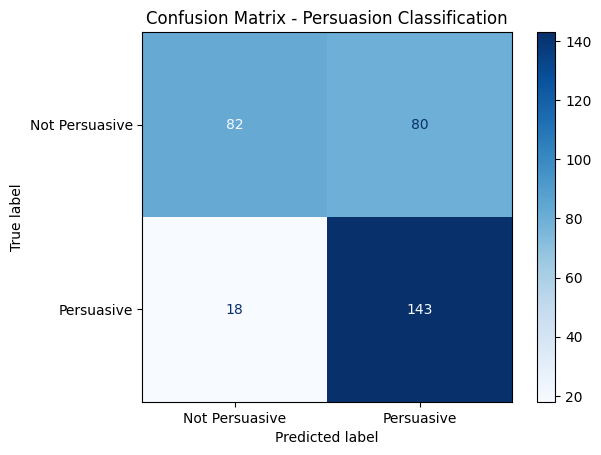


Total misclassified examples: 98

🧩 Text: {'ancestor': 't1_ct5eykr', 'author': 'DoctahDoak', 'comments': [{'subreddit_id': 't5_2w2s8', 'banned_by': None, 'removal_reason': None, 'link_id': 't3_3dh1ns', 'likes': None, 'replies': {'kind': 'Listing', 'data': {'modhash': '', 'children': ['ct5f4og', 'ct5jgab'], 'after': None, 'before': None}}, '...
✅ True: Not Persuasive | ❌ Predicted: Persuasive

🧩 Text: {'ancestor': 't1_cu4mp4v', 'author': 'BreaksFull', 'comments': [{'subreddit_id': 't5_2w2s8', 'banned_by': None, 'removal_reason': None, 'link_id': 't3_3h69kp', 'likes': None, 'replies': {'kind': 'Listing', 'data': {'modhash': '', 'children': ['cu4qg0o', 'cu4mv6l'], 'after': None, 'before': None}}, '...
✅ True: Not Persuasive | ❌ Predicted: Persuasive

🧩 Text: {'ancestor': 't1_ct68xez', 'author': 'nannyhap', 'comments': [{'subreddit_id': 't5_2w2s8', 'banned_by': None, 'removal_reason': None, 'link_id': 't3_3dhde9', 'likes': None, 'replies': {'kind': 'Listing', 'data': {'modhash': '', 'chil

In [33]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


preds_output = trainer.predict(tokenized_test)
y_true = np.array(preds_output.label_ids)
y_pred = np.argmax(preds_output.predictions, axis=1)


print(classification_report(y_true, y_pred, target_names=["Not Persuasive", "Persuasive"]))


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Persuasive", "Persuasive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Persuasion Classification")
plt.show()


wrong_indices = np.where(y_true != y_pred)[0]
print(f"\nTotal misclassified examples: {len(wrong_indices)}\n")

for idx in wrong_indices[:5]:
    true_label = "Persuasive" if y_true[idx] == 1 else "Not Persuasive"
    pred_label = "Persuasive" if y_pred[idx] == 1 else "Not Persuasive"
    text_sample = test_df.iloc[idx]["text"]
    print(f"🧩 Text: {text_sample[:300]}...")
    print(f"✅ True: {true_label} | ❌ Predicted: {pred_label}\n")
